In [1]:
from data.datahandler import datahandler
from data.datareader import datareader
from models.QCNN import *
from utils import test_loader
from utils.plotter import *
from utils.converter import convert_labels_mapper

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Load processed dataset

Instructions
1. the dataset should be placed in the working directory, specifically in the **datasets** folder.
2. the dataset should be already divided into classes, one-subfolder for earch classes. The folder/class name will be used to encode the label

If this script is runned after *Quantum Convolution Processing.ipynb* the folder structure should be alredy ready.

```
QuantumCNN
│   README.md
│   requirements.txt    
│
└───circuits
└───...
└───datasets
    └───EuroSAT
        └───Highway
                highway1.jpg
                highway2.jpg                
        └─── ....
        └───Lake
                lake1.jpg
                lake2.jpg                

```

Given *the dataset_name*, that must be the same of the folder, the **datahandler** will take care of loading the paths of the feature smaps and collected them into a class dictionary. After a report of the dataset will be printed.

In [2]:
dataset_name = 'EuroSAT'
root = os.path.join('datasets', dataset_name)
dhandler = datahandler(root)
dhandler.print_report(name=dataset_name)

Dataset EuroSAT

Class 0 - Forest                    - #images: 3000
Class 1 - River                     - #images: 2500
Class 2 - Highway                   - #images: 2500
Class 3 - AnnualCrop                - #images: 3000
Class 4 - SeaLake                   - #images: 3000
Class 5 - HerbaceousVegetation      - #images: 3000
Class 6 - Industrial                - #images: 2500
Class 7 - Residential               - #images: 3000
Class 8 - PermanentCrop             - #images: 2500
Class 9 - Pasture                   - #images: 2000


In [3]:
train_set, val_set = dhandler.split(None, factor=0.01)
dhandler.print_report(train_set, name=dataset_name+'-Train')
dhandler.print_report(val_set,   name=dataset_name+'-Validation')

Dataset EuroSAT-Train

Class 0 - Forest                    - #images: 2970
Class 1 - River                     - #images: 2475
Class 2 - Highway                   - #images: 2475
Class 3 - AnnualCrop                - #images: 2970
Class 4 - SeaLake                   - #images: 2970
Class 5 - HerbaceousVegetation      - #images: 2970
Class 6 - Industrial                - #images: 2475
Class 7 - Residential               - #images: 2970
Class 8 - PermanentCrop             - #images: 2475
Class 9 - Pasture                   - #images: 1980
Dataset EuroSAT-Validation

Class 0 - Forest                    - #images: 30
Class 1 - River                     - #images: 25
Class 2 - Highway                   - #images: 25
Class 3 - AnnualCrop                - #images: 30
Class 4 - SeaLake                   - #images: 30
Class 5 - HerbaceousVegetation      - #images: 30
Class 6 - Industrial                - #images: 25
Class 7 - Residential               - #images: 30
Class 8 - PermanentCrop      

The **unpack** function trasforms the dataset from a dictionary to an array. It assigns also the label to each image and returns a dictionary mapping the labels with the class name

In [4]:
labels_mapper, x_t, y_t = dhandler.unpack(train_set)
labels_mapper, x_v, y_v = dhandler.unpack(val_set)

print('Train Set')
print('\nLabels')
for key in labels_mapper: print('{:<30s}{}'.format(key,labels_mapper[key]))

print('\nDataset Size')
print('{:<30s}{}'.format('Images', len(x_t)))

print('\nTraining Dataset samples')
print('{:<30s}{}'.format('X Train', x_t[0]))
print('{:<30s}{}'.format('X Train', y_t[0]))

print('\nValidation Set')
print('\nLabels')
for key in labels_mapper: print('{:<30s}{}'.format(key,labels_mapper[key]))

print('\nDataset Size')
print('{:<30s}{}'.format('Images', len(x_v)))

print('\nTraining Dataset samples')
print('{:<30s}{}'.format('X Train', x_v[0]))
print('{:<30s}{}'.format('X Train', y_v[0]))

Train Set

Labels
Forest                        [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
River                         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Highway                       [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
AnnualCrop                    [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
SeaLake                       [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
HerbaceousVegetation          [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Industrial                    [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Residential                   [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
PermanentCrop                 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Pasture                       [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Dataset Size
Images                        26730

Training Dataset samples
X Train                       datasets/EuroSAT/Forest/Forest_864.jpg
X Train                       [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Validation Set

Labels
Forest                        [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
River                         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Highway

Test the keras-like data loader. In this specific case the *datareader.generatorv2* is tested. It contains all the rutines to load images batch by batch (1 in this case).

Reading Image:   0%|          | 0/26730 [00:00<?, ?it/s]

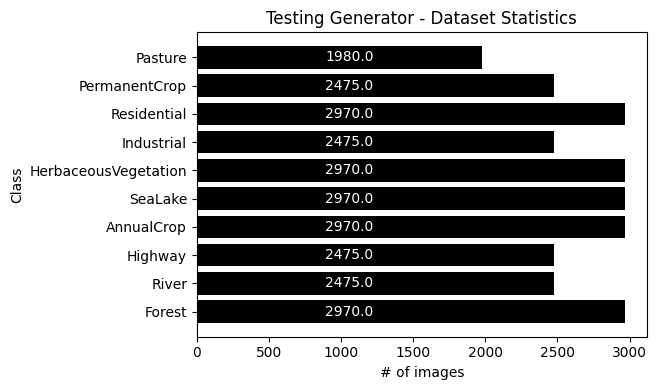

In [5]:
classes = dhandler.paths.keys()
loader  = datareader.generatorv2((x_t, y_t), (31,31,16))
test_loader.dlv2([x_t,y_t], loader, classes)

Reading Image:   0%|          | 0/270 [00:00<?, ?it/s]

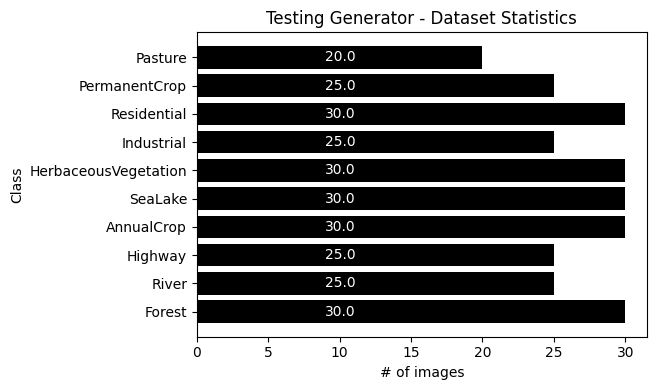

In [6]:
loader  = datareader.generatorv2((x_v, y_v), (31,31,16))
test_loader.dlv2([x_v,y_v], loader, classes)

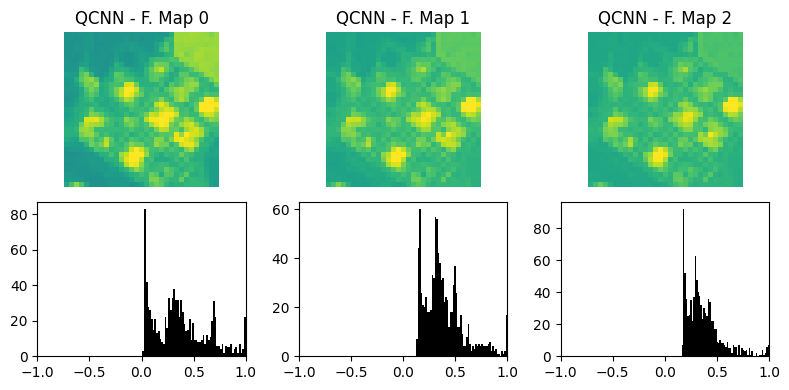

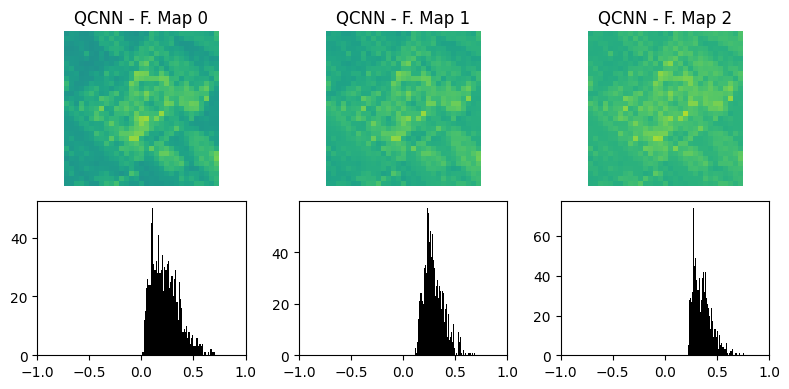

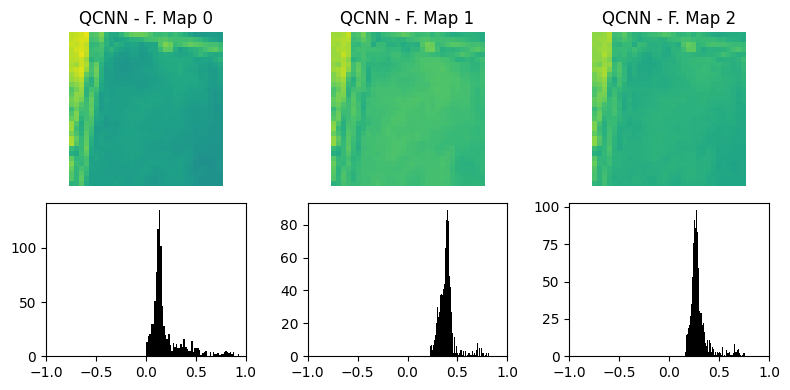

In [7]:
gen = iter(datareader.generator((x_t, y_t), 1, (31,31,3), normalize='true'))
for i in range(3):
    (xi, yi) = next(gen)
    feat_maps = xi[0]
    plot_features_map(feat_maps)

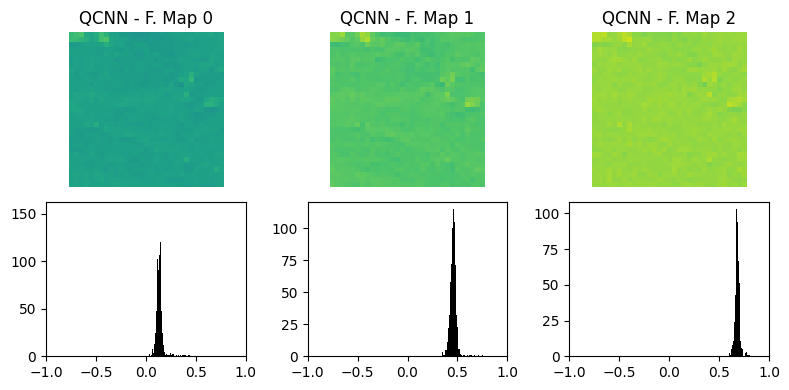

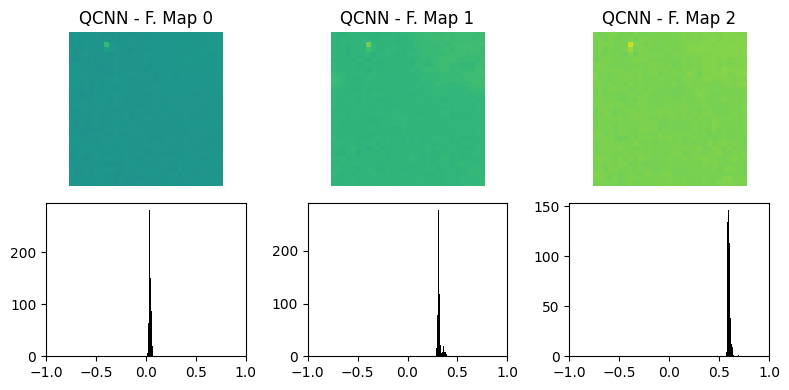

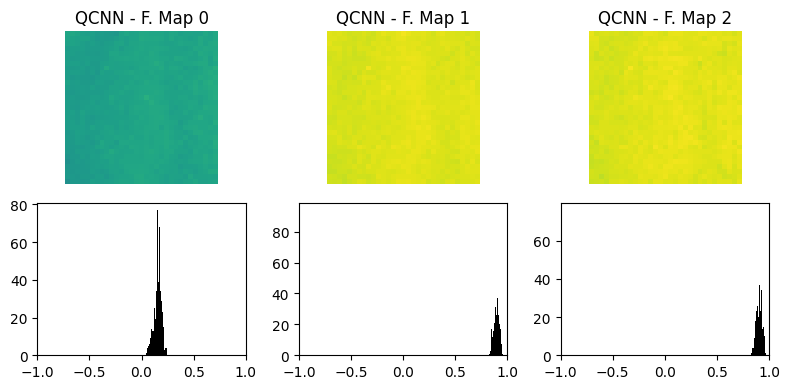

In [8]:
gen = iter(datareader.generator((x_v, y_v), 1, (31,31,3), normalize='true'))
for i in range(3):
    (xi, yi) = next(gen)
    feat_maps = xi[0]
    plot_features_map(feat_maps)

## Hybrid Model

In [9]:
from importlib import reload 
from models import QCNN
reload(QCNN)

qcnn = QCNNv1(img_shape = (31,31,3), n_classes = 10)

In [10]:
qcnn.model.summary()

Model: "QCNNv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 31, 31, 3)]       0         
                                                                 
 activation (Activation)     (None, 31, 31, 3)         0         
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 3)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 675)               0         
                                                                 
 dropout (Dropout)           (None, 675)               0         
                                                                 
 dense (Dense)               (None, 128)               86528     
                                                            

In [11]:
qcnn.train_test([x_v, y_v], [x_v, y_v], convert_labels_mapper(labels_mapper), normalize = None)

Epoch 1/5


2022-10-25 16:49:49.275552: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 1s 19ms/step - loss: 117.3263 - accuracy: 0.1055 - mse: 0.1758 - val_loss: 21.6731 - val_accuracy: 0.1016 - val_mse: 0.1693
Epoch 2/5
16/16 [==============================] - 0s 12ms/step - loss: 71.8185 - accuracy: 0.1094 - mse: 0.1743 - val_loss: 14.2147 - val_accuracy: 0.1250 - val_mse: 0.1618
Epoch 3/5
16/16 [==============================] - 0s 11ms/step - loss: 49.3873 - accuracy: 0.0859 - mse: 0.1778 - val_loss: 13.9466 - val_accuracy: 0.1328 - val_mse: 0.1630
Epoch 4/5
16/16 [==============================] - 0s 11ms/step - loss: 36.3858 - accuracy: 0.1484 - mse: 0.1638 - val_loss: 11.7364 - val_accuracy: 0.0859 - val_mse: 0.1616
Epoch 5/5
16/16 [==============================] - 0s 13ms/step - loss: 33.1752 - accuracy: 0.0938 - mse: 0.1709 - val_loss: 7.6165 - val_accuracy: 0.0820 - val_mse: 0.1485
Model Saved                   results/QCNNv1/25-10-2022-16:49:50/model.h5
History Saved                 results/QCNNv1/25-10-2022-16:49:50/h

  0%|          | 0/270 [00:00<?, ?it/s]

training Results              results/QCNNv1/25-10-2022-16:49:50/training-results.csv
Confusion matrix saved        results/QCNNv1/25-10-2022-16:49:50/training-cf.png


  0%|          | 0/270 [00:00<?, ?it/s]

validation Results            results/QCNNv1/25-10-2022-16:49:50/validation-results.csv
Confusion matrix saved        results/QCNNv1/25-10-2022-16:49:50/validation-cf.png


/Users/asebastianelli/Desktop/QuantumCNN/utils/plotter.py:97: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


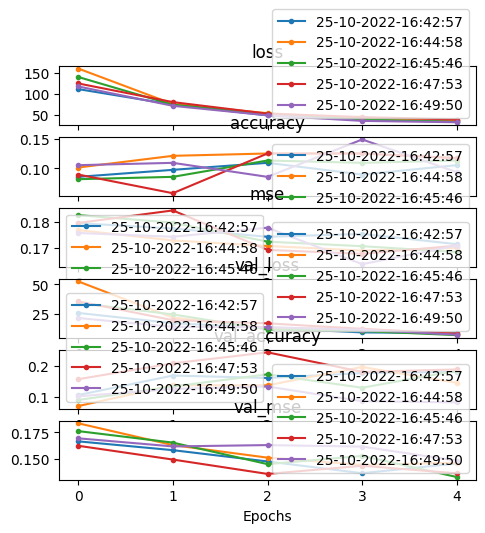

Image saved


In [13]:
from importlib import reload 
from utils import plotter
reload(plotter)

plotter.plot_training('QCNNv1', display = True)